In [1]:
%matplotlib inline
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [2]:
import ndreg
from ndreg import preprocessor, registerer, util
import SimpleITK as sitk
import numpy as np

In [57]:
def normalize(img, percentile=0.99):
    #Accept ndarray images or sitk images
    if type(img) is np.ndarray:
        sitk_img = sitk.GetImageFromArray(img)
    else:
        sitk_img = img
    max_val = ndreg.imgPercentile(sitk_img, percentile)
    return sitk.Clamp(sitk_img, upperBound=max_val) / max_val

In [58]:
def process(im, vmin=0, vmax=65535):
    """
    Input: SITK Image
    Output: Clipped and normalized SITK Image
    """
    temp = np.clip(sitk.GetArrayFromImage(im), vmin, vmax)
    return normalize(temp)


In [59]:
def myshow(img, cmap='gray', colorbar=False):
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=cmap)
    if colorbar: plt.colorbar()
    plt.axis('off')
    plt.show()

In [60]:
def register(im1, im2):
    assert (type(im1) == sitk.SimpleITK.Image
               and type(im2) == sitk.SimpleITK.Image)
    
    depth = max(im1.GetDepth(), im2.GetDepth())
#     print('depth={}'.format(depth))
    
    im1_slices = [im1[:,:,i] for i in range(depth)]
    im2_slices = [im2[:,:,i] for i in range(depth)] 
    im1_processed = sitk.GetImageFromArray(
            [sitk.GetArrayFromImage(process(im1_slices[i], vmin=-3000, vmax=12000)) for i in range(depth)])
    im2_processed = sitk.GetImageFromArray(
            [sitk.GetArrayFromImage(process(im2_slices[i], vmin=-3000, vmax=12000)) for i in range(depth)])

#     print('images processed')
    
#     print('registering')
    final_transform = registerer.register_rigid(im1_processed, im2_processed, learning_rate=1e-1, iters=25)
    
#     print('computing corrected image')
    corrected_img = registerer.resample(im1_processed, final_transform, im2_processed)
    
    return im1_processed, im2_processed, corrected_img

In [61]:
def calculate_error(im1, im2, verbose=False):
    depth = max(im1.GetDepth(), im2.GetDepth())
    errors = []
    for i in range(depth):
        error = registerer.imgMSE(normalize(im1[:,:,i]), normalize(im2[:,:,i]))
        errors.append(error)
        if verbose:
            print("Slice {}: Registration error is: {} voxels^2".format(i, error))
    
    return errors

In [62]:
def plot_error(errors, title="", xlabel="Log Square Voxel Error", ylabel="Slice", save=None):
    plt.clf()
    plt.figure()
    plt.title(title)
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().invert_yaxis()
    plt.plot(np.log10(errors), range(50))

    if save is not None:
        plt.savefig(save)

    plt.show()
    plt.close()

In [225]:
def generate_overlay(im1, im2, title="", save=None):
    depth = max(im1.GetDepth(), im2.GetDepth())
    
    for i in range(depth):
        fig = plt.figure(figsize=(5, 6))
        plt.imshow(sitk.GetArrayViewFromImage(im1[:,:,i]), cmap='Purples', alpha=0.5)
        plt.imshow(sitk.GetArrayViewFromImage(im2[:,:,i]), cmap='Greens', alpha=0.5)
        plt.axis('off')
        plt.title('{}\nSlice {}'.format(title, i))
        if save is not None:
            plt.savefig("{}_slice{:02d}".format(save, i))

        plt.show()
        plt.close()    

## Functions

Functions defined above are for 

* registering  *two* 3-D images by rigid registration (`register`), 
* calculating mean-squared error (`calculate_error`), and 
* plotting overlaid slices (`generate_overlay`)
* plotting mean-squared error (`plot_error`).

Below we demonstrate that they work as expected.

We first read in four images of the same mouse at different timepoints. 

In [9]:
tp1 = util.imgRead('./data/R04_tp1.tif')
tp2 = util.imgRead('./data/R04_tp2.tif')
tp3 = util.imgRead('./data/R04_tp3.tif')
tp4 = util.imgRead('./data/R04_tp4.tif')

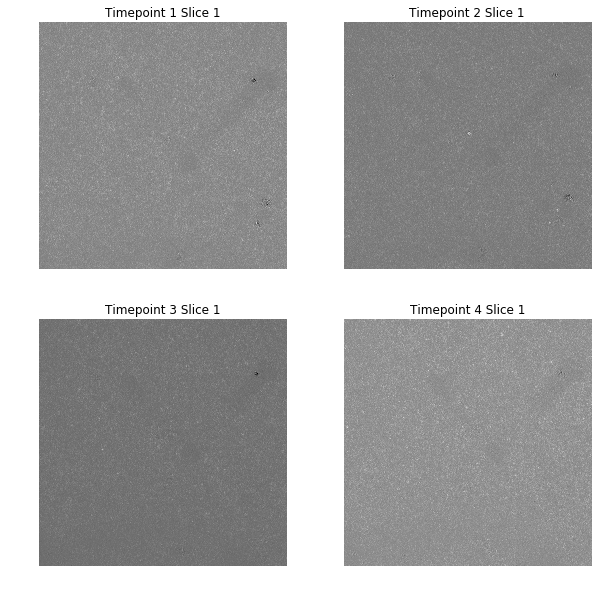

In [174]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(sitk.GetArrayViewFromImage(tp1[:,:,1]), cmap='gray')
plt.title('Timepoint 1 Slice 1')
plt.axis('off')
plt.subplot(222)
plt.imshow(sitk.GetArrayViewFromImage(tp2[:,:,1]), cmap='gray')
plt.title('Timepoint 2 Slice 1')
plt.axis('off')
plt.subplot(223)
plt.imshow(sitk.GetArrayViewFromImage(tp3[:,:,1]), cmap='gray')
plt.title('Timepoint 3 Slice 1')
plt.axis('off')
plt.subplot(224)
plt.imshow(sitk.GetArrayViewFromImage(tp4[:,:,1]), cmap='gray')
plt.title('Timepoint 4 Slice 1')
plt.axis('off')
plt.show()
plt.close()

These images are a little unclear and look like a big mass of gray. To see why, let's look at the image histogram.

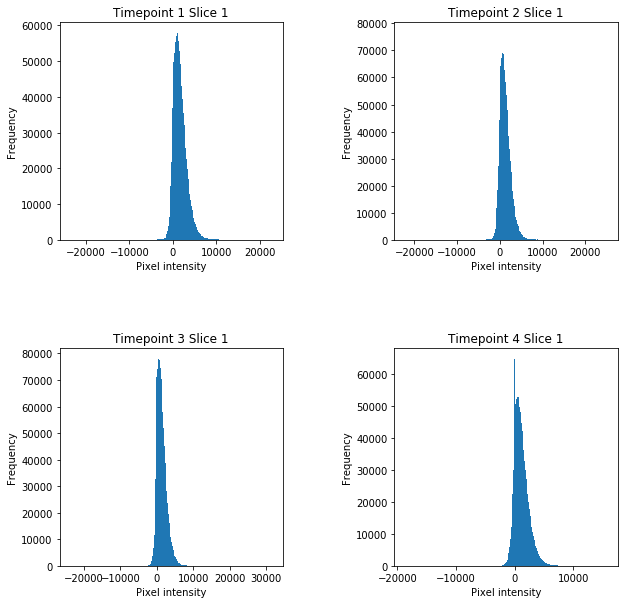

In [205]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(221)
plt.hist(sitk.GetArrayViewFromImage(tp1[:,:,1]).ravel(), bins=256)
plt.title('Timepoint 1 Slice 1')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.subplot(222)
plt.hist(sitk.GetArrayViewFromImage(tp2[:,:,1]).ravel(), bins=256)
plt.title('Timepoint 2 Slice 1')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.subplot(223)
plt.hist(sitk.GetArrayViewFromImage(tp3[:,:,1]).ravel(), bins=256)
plt.title('Timepoint 3 Slice 1')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.subplot(224)
plt.hist(sitk.GetArrayViewFromImage(tp4[:,:,1]).ravel(), bins=256)
plt.title('Timepoint 4 Slice 1')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

plt.show()
plt.close()

Most of pixel intensity values are in the middle of the range of intensities! To see which pixels are setting range so far out, let's color them red.

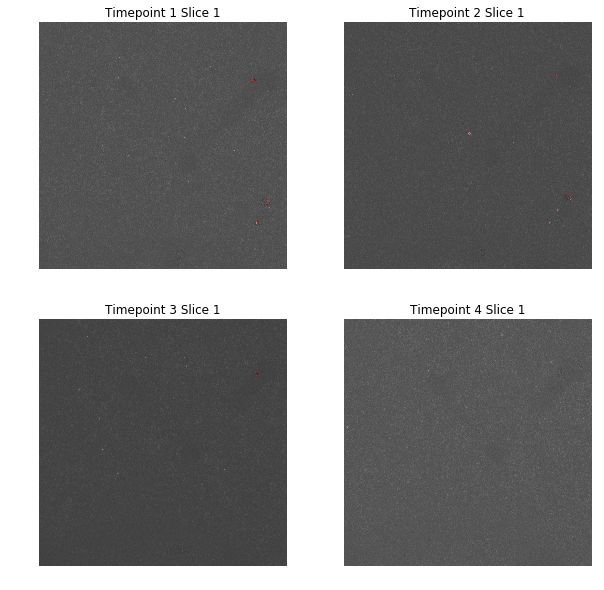

In [178]:
plt.figure(figsize=(10,10))
plt.subplot(221)
ar1 = sitk.GetArrayFromImage(tp1[:,:,1])
mask11 = ar1 > 10000
mask12 = ar1 < -5000
mask1 = np.stack([255*(mask11+mask12), np.zeros(mask11.shape), np.zeros(mask11.shape)], axis=2).astype(np.uint8)
plt.imshow(ar1, cmap='gray')
plt.imshow(mask1, alpha=0.4)
plt.title('Timepoint 1 Slice 1')
plt.axis('off')

plt.subplot(222)
ar2 = sitk.GetArrayFromImage(tp2[:,:,1])
mask21 = ar2 > 10000
mask22 = ar2 < -5000
mask2 = np.stack([255*(mask21+mask22), np.zeros(mask21.shape), np.zeros(mask21.shape)], axis=2).astype(np.uint8)
plt.imshow(ar2, cmap='gray')
plt.imshow(mask2, alpha=0.4)
plt.title('Timepoint 2 Slice 1')
plt.axis('off')

plt.subplot(223)
ar3 = sitk.GetArrayFromImage(tp3[:,:,1])
mask31 = ar3 > 10000
mask32 = ar3 < -5000
mask3 = np.stack([255*(mask31+mask32), np.zeros(mask31.shape), np.zeros(mask31.shape)], axis=2).astype(np.uint8)
plt.imshow(ar3, cmap='gray')
plt.imshow(mask3, alpha=0.4)
plt.title('Timepoint 3 Slice 1')
plt.axis('off')

plt.subplot(224)
ar4 = sitk.GetArrayFromImage(tp4[:,:,1])
mask41 = ar4 > 10000
mask42 = ar4 < -5000
mask4 = np.stack([255*(mask41+mask42), np.zeros(mask41.shape), np.zeros(mask41.shape)], axis=2).astype(np.uint8)
plt.imshow(ar4, cmap='gray')
plt.imshow(mask4, alpha=0.4)
plt.title('Timepoint 4 Slice 1')
plt.axis('off')
plt.show()
plt.close()

In [196]:
print('{:.5f}% of Timepoint 1 has pixel intensity outside [-5000, 10000]'.format(float(np.count_nonzero(mask1))/np.size(ar1) * 100))
print('{:.5f}% of Timepoint 2 has pixel intensity outside [-5000, 10000]'.format(float(np.count_nonzero(mask2))/np.size(ar2) * 100))
print('{:.5f}% of Timepoint 3 has pixel intensity outside [-5000, 10000]'.format(float(np.count_nonzero(mask3))/np.size(ar3) * 100))
print('{:.5f}% of Timepoint 4 has pixel intensity outside [-5000, 10000]'.format(float(np.count_nonzero(mask4))/np.size(ar4) * 100))

0.06590% of Timepoint 1 has pixel intensity outside [-5000, 10000]
0.04139% of Timepoint 2 has pixel intensity outside [-5000, 10000]
0.02470% of Timepoint 3 has pixel intensity outside [-5000, 10000]
0.00906% of Timepoint 4 has pixel intensity outside [-5000, 10000]


Doesn't look like much, but if we now process the images by clipping extreme values (those beyond -5000 and 10000), the image becomes significantly clearer.

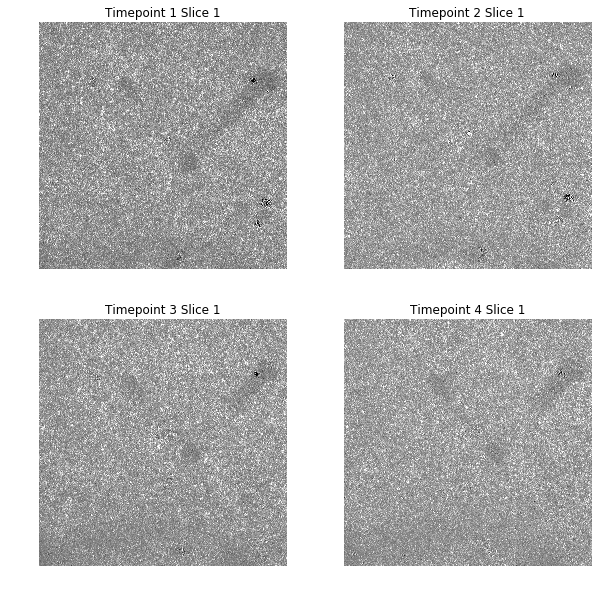

In [197]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(sitk.GetArrayViewFromImage(process(tp1[:,:,1], vmin=-5000, vmax=10000)), cmap='gray')
plt.title('Timepoint 1 Slice 1')
plt.axis('off')
plt.subplot(222)
plt.imshow(sitk.GetArrayViewFromImage(process(tp2[:,:,1], vmin=-5000, vmax=10000)), cmap='gray')
plt.title('Timepoint 2 Slice 1')
plt.axis('off')
plt.subplot(223)
plt.imshow(sitk.GetArrayViewFromImage(process(tp3[:,:,1], vmin=-5000, vmax=10000)), cmap='gray')
plt.title('Timepoint 3 Slice 1')
plt.axis('off')
plt.subplot(224)
plt.imshow(sitk.GetArrayViewFromImage(process(tp4[:,:,1], vmin=-5000, vmax=10000)), cmap='gray')
plt.title('Timepoint 4 Slice 1')
plt.axis('off')
plt.show()

Looking at the histogram also shows that there aren't as many outliers. Of course we will have spikes at the edges where we clipped the image, but these frequencies are small relative to the rest of the frequencies of pixel intensity.

In these graphs, we have pixel values in the range [-1,1] but this is just a rescaling.

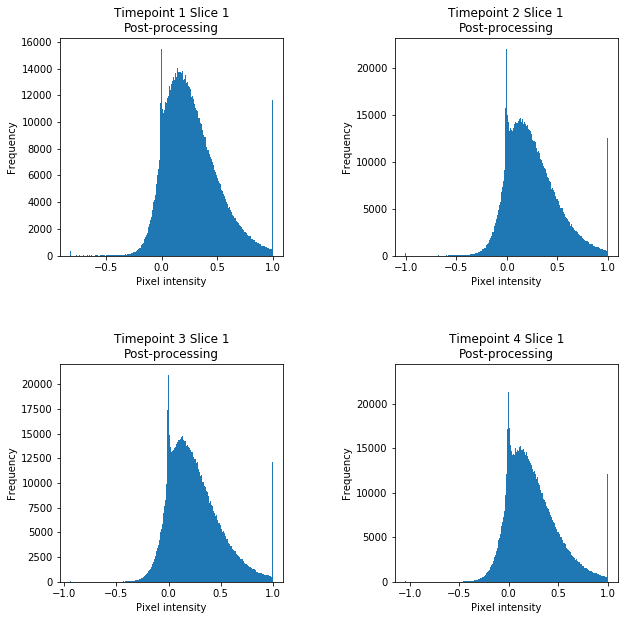

In [206]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(221)
plt.hist(sitk.GetArrayViewFromImage(process(tp1[:,:,1], vmin=-5000, vmax=10000)).ravel(), bins=256)
plt.title('Timepoint 1 Slice 1\nPost-processing')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.subplot(222)
plt.hist(sitk.GetArrayViewFromImage(process(tp2[:,:,1], vmin=-5000, vmax=10000)).ravel(), bins=256)
plt.title('Timepoint 2 Slice 1\nPost-processing')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.subplot(223)
plt.hist(sitk.GetArrayViewFromImage(process(tp3[:,:,1], vmin=-5000, vmax=10000)).ravel(), bins=256)
plt.title('Timepoint 3 Slice 1\nPost-processing')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.subplot(224)
plt.hist(sitk.GetArrayViewFromImage(process(tp4[:,:,1], vmin=-5000, vmax=10000)).ravel(), bins=256)
plt.title('Timepoint 4 Slice 1\nPost-processing')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

plt.show()
plt.close()

Now, after we've processed the images, let's register them.

In [16]:
im1, im2, corrected12 = register(tp1, tp2)

depth=50


How does our registration look, visually and quantitatively?

First, let's look at an overlay plot. The timepoint 1 image is in purple, and the corrected timepoint 2 image is in green, and the images are blended with an $\alpha=0.5$ for each image. In particular, in the gif, any grayscale areas represent the areas of best overlap -- this would occur when the green and purple (red + blue) values are all equal. The most obvious examples are the black and white areas -- these are a lot better with processing.


<p>
Without processing, there are high variations in intensity and there are very few aligned areas on the overlay images.
</p>

<img align='left' src='output/tp1tp2.gif' width="500"/> 

<img align='left' src='output/tp1tp2_noprocess.gif' width="500"/>


Let's look at the mean-squared error between the images. 

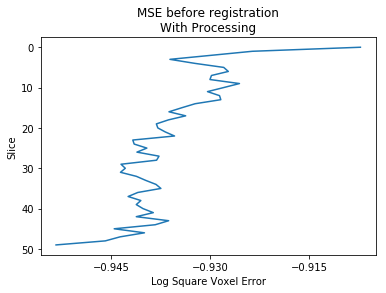

In [227]:
errors = calculate_error(im1, im2)
plot_error(errors, title='MSE before registration\nWith Processing')

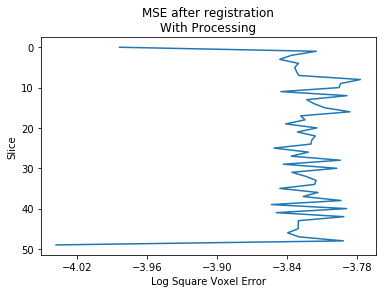

In [228]:
errors = calculate_error(im1, corrected12)
plot_error(errors, title='MSE after registration\nWith Processing')

<p>
<img align='left' src='output/voxelerror12_noprocess.png'>
</p>
Compare this with the MSE after registration without processing.

Clearly processing helps a bunch -- the error before registration with processing is about the same as the error after registration without processing. Furthermore the MSE decreased by almost 3 orders of magnitude when comparing the post-registration images with and without processing. 